In [4]:
from datetime import datetime
import numpy as np             #for numerical computations like log,exp,sqrt etc
import pandas as pd            #for reading & storing data, pre-processing
import matplotlib.pylab as plt #for visualization
from statsmodels.tsa.seasonal import seasonal_decompose 
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [5]:
# Read the AirPassengers dataset 
airline = pd.read_excel(r"C:\Users\91887\OneDrive\Documents\Trim IV\Predictive Analytics\AirPassengers.xlsx", 
                       index_col ='Month', 
                       parse_dates = True) 
  
# Print the first five rows of the dataset 
airline.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


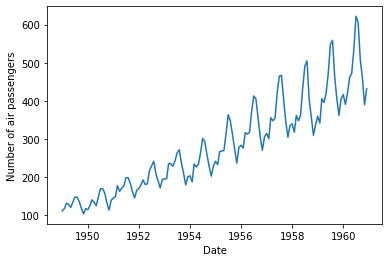

In [6]:
## plot graph
plt.xlabel('Date')
plt.ylabel('Number of air passengers')
plt.plot(airline)

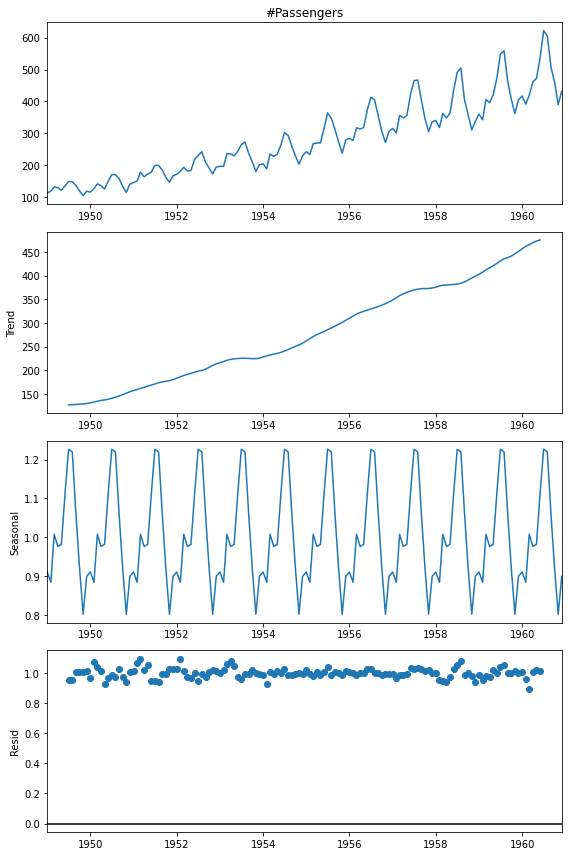

In [7]:
from matplotlib import pyplot
plt.rcParams["figure.figsize"] = (8,12)
result = seasonal_decompose(airline['#Passengers'],  
                            model ='multiplicative') 
result.plot()
pyplot.show()
## to show the trend,seasonality and randomness

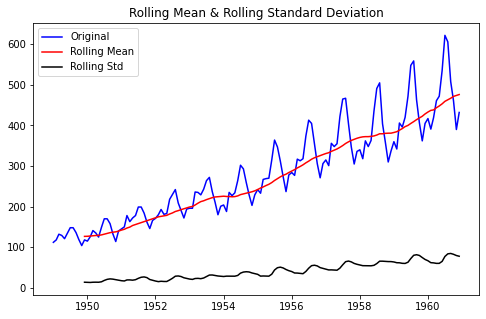

In [8]:
##to check the stationarity
plt.rcParams["figure.figsize"] = (8,5)
rolling_mean = airline.rolling(window = 12).mean()
rolling_std = airline.rolling(window = 12).std()
plt.plot(airline, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()
##rolling mean and rolling standard deviation increase with time. so  non stationary

In [9]:
#adf for stationary check
result = adfuller(airline['#Passengers'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))
##p value is greater than 0.05. so time series is not stationary

ADF Statistic: 0.8153688792060543
p-value: 0.9918802434376411
Critical Values:
	1%: -3.4816817173418295
	5%: -2.8840418343195267
	10%: -2.578770059171598


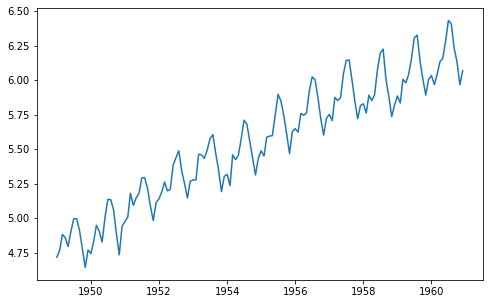

In [10]:
##Taking the log of the dependent variable is as simple way of lowering the rate at which rolling mean increases.
df_log = np.log(airline)
plt.plot(df_log)

In [11]:
## to check stationarity on new dataset
def get_stationarity(timeseries):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()
    
    # rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Dickey–Fuller test:
    result = adfuller(timeseries['#Passengers'])
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

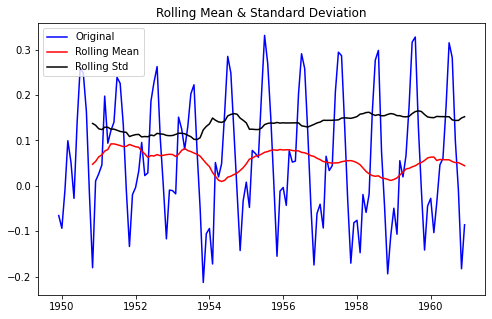

ADF Statistic: -3.162907991300852
p-value: 0.022234630001244236
Critical Values:
	1%: -3.4865346059036564
	5%: -2.8861509858476264
	10%: -2.579896092790057


In [12]:
##subtracting the rolling mean
rolling_mean = df_log.rolling(window=12).mean()
df_log_minus_mean = df_log - rolling_mean
df_log_minus_mean.dropna(inplace=True)
get_stationarity(df_log_minus_mean)
##here rolling mean and rolling std dev are approximately horizontal and parallel to each other
## and p<0.05. 
## so data is now stationary

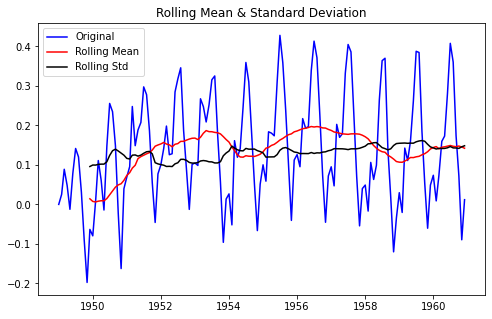

ADF Statistic: -3.601262420161675
p-value: 0.0057369388015119215
Critical Values:
	1%: -3.4816817173418295
	5%: -2.8840418343195267
	10%: -2.578770059171598


In [13]:
##checking stationarity using exponential decay
rolling_mean_exp_decay = df_log.ewm(halflife=12, min_periods=0, adjust=True).mean()
df_log_exp_decay = df_log - rolling_mean_exp_decay
df_log_exp_decay.dropna(inplace=True)
get_stationarity(df_log_exp_decay)
##p<0.05. stationary

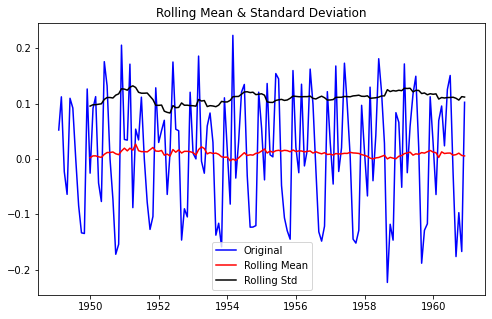

ADF Statistic: -2.7171305983881595
p-value: 0.07112054815085424
Critical Values:
	1%: -3.4825006939887997
	5%: -2.884397984161377
	10%: -2.578960197753906


In [14]:
##checking stationarity from log shift
df_log_shift = df_log - df_log.shift()
df_log_shift.dropna(inplace=True)
get_stationarity(df_log_shift)
##p>0.05. not acceptable

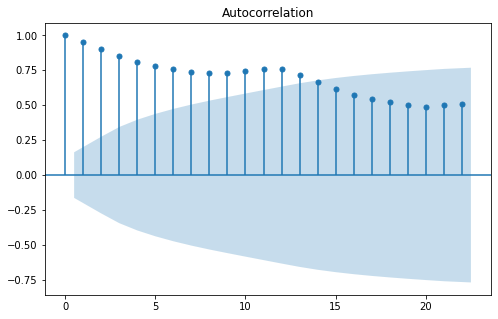

In [15]:
##ARMA model
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(df_log)
pyplot.show()
##p=14

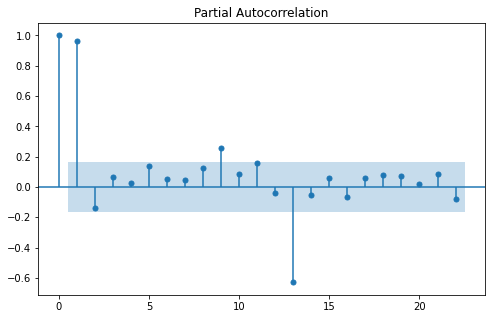

In [16]:
plot_pacf(df_log)
pyplot.show()
#q=2

C:\Users\91887\Downloads\anaconda\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\91887\Downloads\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferr

Plotting AR model


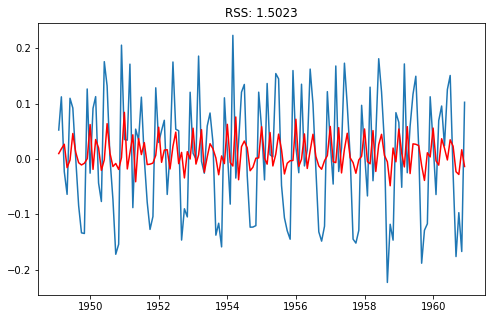

In [17]:
#AR Model
#making order=(2,1,0) gives RSS=1.5023
model = ARIMA(df_log, order=(2,1,0))
results_AR = model.fit(disp=-1)
plt.plot(df_log_shift)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_AR.fittedvalues - df_log_shift['#Passengers'])**2))
print('Plotting AR model')

C:\Users\91887\Downloads\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\91887\Downloads\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Plotting MA model


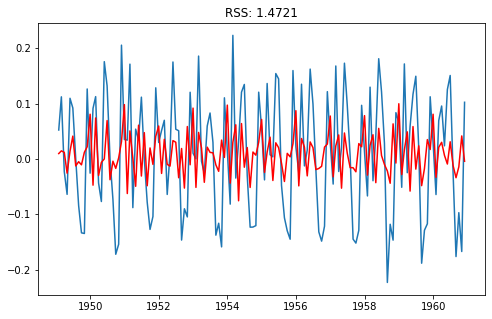

In [18]:
#MA Model
model = ARIMA(df_log, order=(0,1,2))
results_MA = model.fit(disp=-1)
plt.plot(df_log_shift)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_MA.fittedvalues - df_log_shift['#Passengers'])**2))
print('Plotting MA model')

C:\Users\91887\Downloads\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Plotting ARIMA model


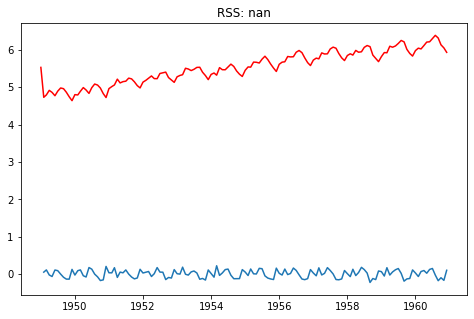

In [19]:
# AR+I+MA = ARIMA model
model = ARIMA(df_log, order=(3,0,2))
results_ARIMA = model.fit(disp=-1)
plt.plot(df_log_shift)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_ARIMA.fittedvalues - df_log_shift['#Passengers'])**2))
print('Plotting ARIMA model')

In [20]:
print(results_ARIMA.summary())

                              ARMA Model Results                              
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                     ARMA(3, 2)   Log Likelihood                 144.147
Method:                       css-mle   S.D. of innovations              0.086
Date:                Wed, 16 Sep 2020   AIC                           -274.295
Time:                        19:47:21   BIC                           -253.506
Sample:                    01-01-1949   HQIC                          -265.847
                         - 12-01-1960                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 5.5309      0.529     10.462      0.000       4.495       6.567
ar.L1.#Passengers     2.6797      0.030     90.255      0.000       2.622       2.738
ar.L2.#Passengers    -2.

In [21]:
##Prediction & Reverse transformations

In [22]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

Month
1949-01-01    5.530922
1949-02-01    4.730779
1949-03-01    4.794663
1949-04-01    4.916636
1949-05-01    4.862060
dtype: float64


In [23]:
#Convert to cumulative sum
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum)

Month
1949-01-01      5.530922
1949-02-01     10.261701
1949-03-01     15.056364
1949-04-01     19.973000
1949-05-01     24.835060
                 ...    
1960-08-01    771.990254
1960-09-01    778.307382
1960-10-01    784.441763
1960-11-01    790.494517
1960-12-01    796.427939
Length: 144, dtype: float64


In [24]:
predictions_ARIMA_log = pd.Series(df_log['#Passengers'].iloc[0], index=df_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head()

Month
1949-01-01    10.249421
1949-02-01    14.980200
1949-03-01    19.774862
1949-04-01    24.691499
1949-05-01    29.553559
dtype: float64

In [25]:
# Inverse of log is exp.
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(airline)
plt.plot(predictions_ARIMA)
##op predicted is very close to real time series data

C:\Users\91887\Downloads\anaconda\lib\site-packages\matplotlib\ticker.py:2234: RuntimeWarning: overflow encountered in multiply
  steps = self._extended_steps * scale
C:\Users\91887\Downloads\anaconda\lib\site-packages\matplotlib\ticker.py:2266: RuntimeWarning: overflow encountered in double_scalars
  high = edge.ge(_vmax - best_vmin)
C:\Users\91887\Downloads\anaconda\lib\site-packages\matplotlib\ticker.py:2078: RuntimeWarning: invalid value encountered in double_scalars
  d, m = divmod(x, self.step)


Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x000001B61A75DA68> (for post_execute):


ValueError: arange: cannot compute length

ValueError: arange: cannot compute length

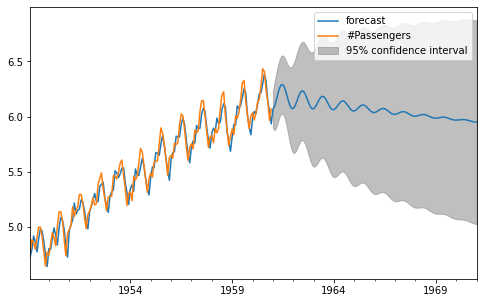

In [26]:
#We have 144(existing data of 12 yrs in months) data points. 
#And we want to forecast for additional 120 data points or 10 yrs.
results_ARIMA.plot_predict(1,264) 
pyplot.show()
#x=results_ARIMA.forecast(steps=120)

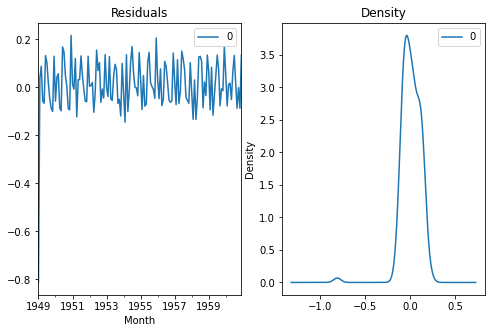

In [27]:
# Plot residual errors
residuals = pd.DataFrame(results_ARIMA.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [28]:
from statsmodels.stats.diagnostic import acorr_ljungbox
#LJung Box Test
acorr_ljungbox(residuals, lags = 12)
##p are less than 0.05

C:\Users\91887\Downloads\anaconda\lib\site-packages\statsmodels\stats\diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


(array([ 0.17496643,  6.03177758,  6.20413469,  7.79946001,  7.92789747,
        10.87687172, 11.24739669, 14.68775142, 14.7633835 , 17.52192895,
        18.79992502, 58.69847676]),
 array([6.75735180e-01, 4.90022635e-02, 1.02090159e-01, 9.92066825e-02,
        1.60254363e-01, 9.22572221e-02, 1.28185838e-01, 6.55089743e-02,
        9.76438613e-02, 6.35837499e-02, 6.47808319e-02, 3.89373066e-08]))

In [29]:
## we need to check ARIMA results for different values of p and q and d